In [1]:
import random

import linear_unpredictability as linupred
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import real_data_loader
import torch
import train_garch

## Set seeds for reconstruction of the results

In [2]:
# Set seeds.
SEED = 12345
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

#### Load Data

Filter out selected times and stocks

In [3]:
real_loader = real_data_loader.RealDataLoader(cache="../data/cache")
real_data = real_loader.get_timeseries(
    col_name="Adj Close", data_path="../data/raw_yahoo_data", update_all=False
)

Cached data found at ../data/cache/time_series_Adj_Close.csv.


Inspect data for missing information

In [4]:
N_TICKS = 9216
nan_mask = ~np.isnan(real_data)  # returns pd.dataframe
num_non_nans: pd.DataFrame = np.sum(nan_mask, axis=0)
non_nan_orderd_stocks: pd.DataFrame = num_non_nans.sort_values(ascending=False)
# plt.plot(non_nan_orderd_stocks.values)
stocks = non_nan_orderd_stocks.iloc[non_nan_orderd_stocks.values >= N_TICKS].index

In [5]:
first_date = real_data.index[-N_TICKS]
real_data = real_data.loc[first_date:, stocks]
assert np.all(~np.isnan(real_data))
print(f"Shape: {real_data.shape}")

Shape: (9216, 233)


Comptue log returns

In [6]:
np_data = np.array(real_data)
np_log_ret = np.log(np_data[1:] / np_data[:-1])
np_log_ret[np.abs(np_log_ret) >= 2] = 0  # clean data

## Real Data inspection

Real data linear unpred corr 0.07907369970248174
Real data linear unpred p_value 0.012373134651523881
Real data linear unpred slope 1.0443572838383787e-06
Real data linear unpred intercept -0.0007865549170994668
Real data linear unpred mse 0.0001392362375568713
Real data linear unpred mse_std 2.9113411556717668e-05


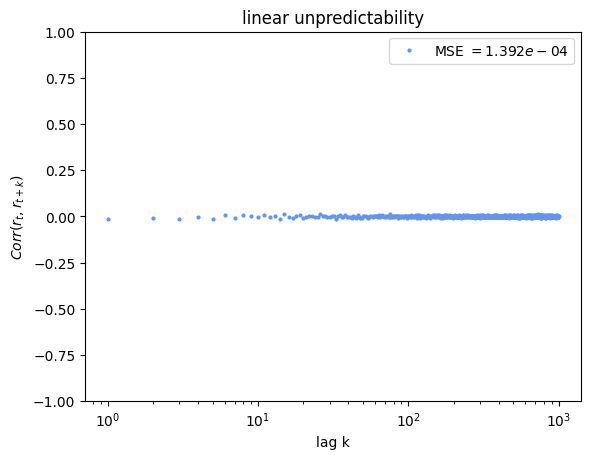

In [7]:
stats = ["corr", "p_value", "slope", "intercept", "mse", "mse_std"]
linupred.visualize_stat(plt.gca(), np_log_ret, "Real data", stats)
# plt.savefig("/home/nico/edu/masterthesis/presentations/week16/figures/ht.png")
plt.show()

## Garch Normal, p=3, q=3

In [8]:
cache = "../data/cache/Garch_normal_3_3_2024_06_26-11_11_24"
garch_log_rets = train_garch.sample_garch(cache)

# Drop bad fits
garch_log_rets = garch_log_rets[:, np.sum(np.isnan(garch_log_rets), axis=0) == 0]

/home/nico/edu/masterthesis/code/src/garch/train_garch.py:133: RuntimeWarning: invalid value encountered in log
  log_returns.append(np.log(return_simulation))


 GARCH normal 3 3 data linear unpred corr -0.11931295487003765
 GARCH normal 3 3 data linear unpred p_value 0.00015569566292072834
 GARCH normal 3 3 data linear unpred slope -3.211967606391326e-07
 GARCH normal 3 3 data linear unpred intercept 6.689212326249061e-05
 GARCH normal 3 3 data linear unpred mse 0.00014243464466494985
 GARCH normal 3 3 data linear unpred mse_std 3.355043815966441e-05


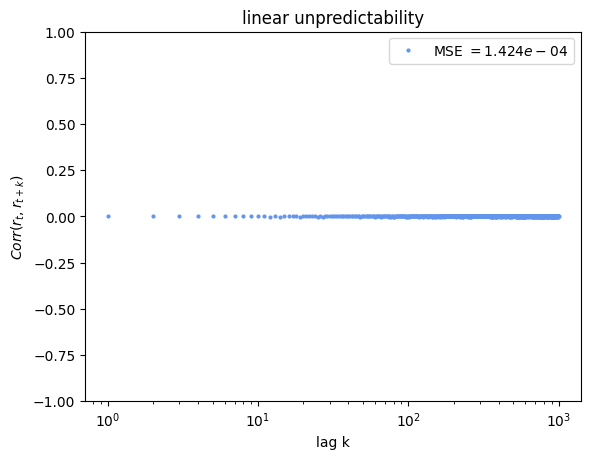

In [9]:
stats = ["corr", "p_value", "slope", "intercept", "mse", "mse_std"]
linupred.visualize_stat(plt.gca(), garch_log_rets, " GARCH normal 3 3 data", stats)
# plt.savefig("/home/nico/edu/masterthesis/presentations/week16/figures/ht.png")
plt.show()